# Lunar Lander ELM

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import cProfile, pstats
import gc
import pickle
from tqdm.notebook import trange

import sys
import os
sys.path.append("../")

from QLearn import *

In [4]:
def heuristic(s):
    # Heuristic for:
    # 1. Testing. 
    # 2. Demonstration rollout.
    if len(s)==1:
        s = s[0]
    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center (s[0] is horizontal coordinate, s[2] hor speed)
    if angle_targ >  0.4: angle_targ =  0.4  # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proporional to horizontal offset

    # PID controller: s[4] angle, s[5] angularSpeed
    angle_todo = (angle_targ - s[4])*0.5 - (s[5])*1.0
    #print("angle_targ=%0.2f, angle_todo=%0.2f" % (angle_targ, angle_todo))

    # PID controller: s[1] vertical coordinate s[3] vertical speed
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5
    #print("hover_targ=%0.2f, hover_todo=%0.2f" % (hover_targ, hover_todo))

    if s[6] or s[7]: # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    a = 0
    if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
    elif angle_todo < -0.05: a = 3
    elif angle_todo > +0.05: a = 1
    return a

def random_agent(s):
    return np.random.randint(4)

In [5]:
env = Environment("LunarLander-v2")
gc.enable()
agent = QAgent(env,net_type='ELMNet',f_heur=heuristic,n_heur=50,N_hid=60,gamma_reg=1e-5,gamma=0.6,eps0=0.5,n_eps=2000,minibatch_size=2,memory_size=100000)
R, steps, agent, _ = do_run(agent, env, 2200, save_name = 'eqlm_lander_new.pkl', show_progress=True)
gc.disable()

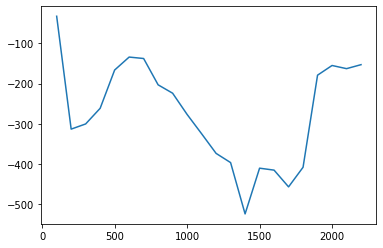

In [6]:
x,R_s = R.smooth()
plt.plot(x,R_s)

In [21]:
del agent

## Demo Memory

In [8]:
env = Environment("LunarLander-v2")
demo_mem = ReplayMemory()
t = trange(100, desc='bar_desc', leave=True)
for ep_no in t:
    s = env.reset()
    done = False
    Rt = 0
    n_step = 0
    while not done:
        prev_s=s
        a = heuristic(s)
        s, r, done, _ = env.step(a)
        demo_mem.add([prev_s.reshape(-1),a,r,s.reshape(-1),done])
        Rt += r
        n_step +=1
    t.set_description('R: {} Step: {}'.format(Rt,n_step))

In [10]:
pickle.dump(demo_mem,open('lunland_demo.pkl','wb'))

Running lander with demo

In [5]:
dmem=pickle.load(open('lunland_demo.pkl','rb'))
env = Environment("LunarLander-v2")
agent = QAgent(env,net_type='QNet',N_hid=60,alpha=1e-3,gamma=0.99,eps0=0.9,n_eps=1500,minibatch_size=20,memory_size=100000,demo_memory=dmem,n_demo=20)
fname = 'lander_demo_19_3'
run_no = 0
asdf = os.listdir()
for a in asdf:
    if a.startswith(fname):
        run_no+=1
R, steps, agent, env = do_run(agent, env, 2200, save_name = fname + str(run_no), show_progress=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


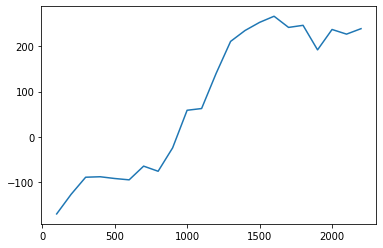

In [6]:
x,R_s = R.smooth()
plt.plot(x,R_s)

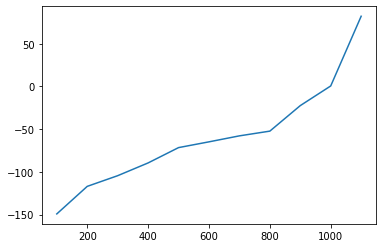

In [9]:
x,R_s = asdf['R'].smooth()
plt.plot(x,R_s)

In [7]:
R_dem, step_dem = agent_demo(agent,env,5,show=True)

In [8]:
env.gym_env.close()

In [10]:
del agent